# Exploring the stats on the leaderboard

# REWRITE THIS TO BE CLEARER

Hi everybody I'm MRQUANTSALOT and made this nodebook to do some data analysis on the leaderboard. 


If you have any feedback or suggestions please let me know in this forum post "link to forum"

This notebook does the following:

1. Ping the Leaderboard and cast it as a Pandas Dataframe
2. Graphs of the distribtion and correlation between some variables. 
3. OLS regression on between varaibles and returns.
4. Creates SQL table you can run SQL Against to get more precise  ( NOT DONE)


In [94]:
!pip install numpy
!pip install pandas 
!pip install json 
!pip install requests 
!pip install matplotlit
!pip install statsmodels 

You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement matplotlit (from versions: none)
ERROR: No matching distribution found for matplotlit
You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# Import packages

In [95]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ping the Leaderboard

In [96]:
def get_leaderboard() -> pd.DataFrame:
    """
        Ping the Numerai leaderboard and return a Pandas DataFrame of the contents.
        https://numer.ai/tournament

    """
    url = 'https://api-tournament.numer.ai/'
    # this is a graph QL query, that lets me get exaclty and only the data I want. 
    query = """{ 
	v2Leaderboard {
	    returns
        corrRep
        fncRep
        mmcRep
        username
        nmrStaked
        returns 
        return_52Weeks
        return_13Weeks
        rank
	    }  
    }"""
    r = requests.post(url=url, json={'query': query})
    json_data = json.loads(r.text)
    df_data = json_data['data']['v2Leaderboard']
    df = pd.DataFrame(df_data)
    df.convert_dtypes() # the auto casts the columns into what it thinks is the most appropriate 
    df['nmrStaked'] = pd.to_numeric(df['nmrStaked'])
    df = df.rename(columns={'returns': '1D_returns', 'return_13Weeks': '3M_returns', 'return_52Weeks': '1Y_returns'})
    return df

df =  get_leaderboard()
print(df.count())
df.head()


corrRep       5126
fncRep        5126
mmcRep        5126
nmrStaked     5126
rank          5126
3M_returns    1871
1Y_returns     398
1D_returns    2395
username      5126
dtype: int64


,corrRep,fncRep,mmcRep,nmrStaked,rank,3M_returns,1Y_returns,1D_returns,username
0,0.051299,0.013977,0.023419,775.855097,1,161.226172,NaN,-2.208261,quantyquant
1,0.048649,0.008177,0.021808,931.557869,2,156.947646,509.068926,-3.127175,benben11
2,0.048194,0.025251,0.019872,95.382757,3,55.924323,217.778678,-2.875499,labrat
3,0.042151,0.018633,0.014259,0.000000,4,NaN,NaN,NaN,ezekiel_47_v12
4,0.041467,0.015879,0.016793,0.000000,5,NaN,NaN,0.912701,uuazed4


# Methods to create plots

### Each method has the optional param min_stake. Use it to exclude smaller stakeing users. 


In [97]:
def create_box_plot(df, col='corrRep', min_stake=0):
    x = df[(df[col].notnull()) & (df['nmrStaked'] > min_stake)][col]
    is_null = df[(df[col].notnull() == False)][col]
    print(is_null.head())
    plt.boxplot(x, vert=False)
    num_elements = x.count()
    plt.title(
        f'Distribution of {col} nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    plt.xlabel(col)
    plt.show()


def create_scatter_plot(df, x_name='corrRep', y_name='fncRep', min_stake=0):
    x = df[(df[x_name].notnull()) & (df['nmrStaked'] > min_stake)][x_name]
    y = df[(df[x_name].notnull()) & (df['nmrStaked'] > min_stake)][y_name]
    plt.scatter(x, y, s=.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    num_elements = x.count()
    plt.title(
        f'{y_name} v {x_name} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    plt.show()


def create_histogram(df, col='corrRep', bins=50, min_stake=0):
    x = df[(df[col].notnull()) & (df['nmrStaked'] > min_stake)][col]
    plt.hist(x, bins)
    plt.xlabel(col)
    plt.ylabel('Count')
    num_elements = x.count()
    plt.title(
        f'Histogram of {col} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    plt.show()


# Change the plot sizes to fit your screen
plt.rcParams["figure.figsize"] = (6,6)

Series([], Name: corrRep, dtype: float64)


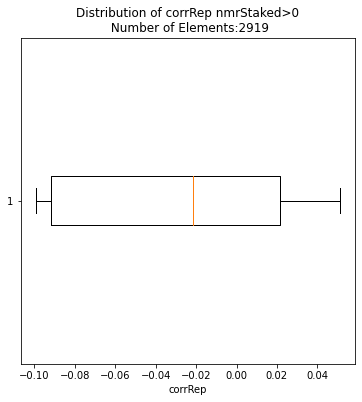

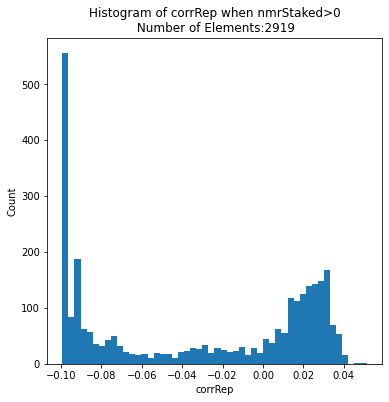

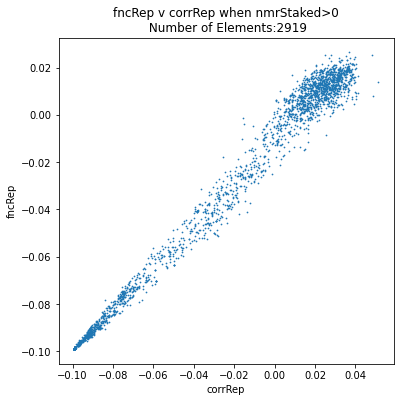

In [98]:
create_box_plot(df, min_stake=0)
create_histogram(df, min_stake=0)
create_scatter_plot(df, min_stake=0)

# Graphs of only the Users with a stake >100

Series([], Name: corrRep, dtype: float64)


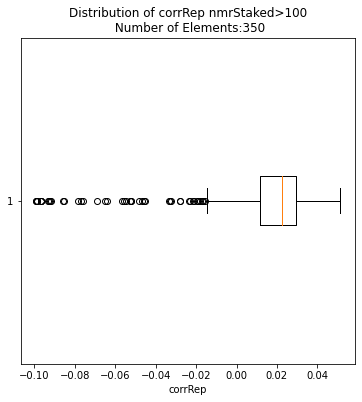

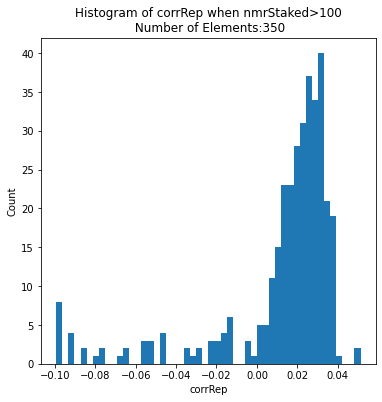

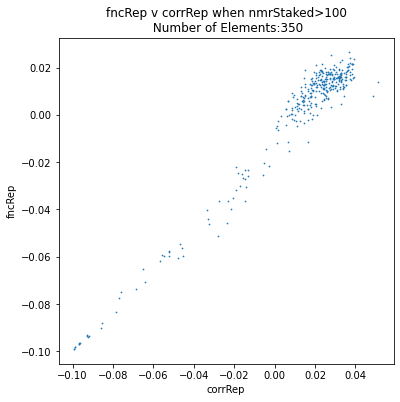

In [99]:
create_box_plot(df, min_stake=100)
create_histogram(df, min_stake=100)
create_scatter_plot(df, min_stake=100)

This makes intutive sense the people who are staking larger amounts of money on their models probobly have better models than your average Joe.

## Methods to compute Ordinary Least Squares regresssion. 


In [100]:
def compute_single_regression(df,
                              independent_variable='corrRep',
                              dependent_variable='3M_returns',
                              min_stake=0):

    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][independent_variable]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())


def compute_multiple_regression(
        df,
        indepenent_variables=['corrRep', 'fncRep', 'mmcRep', 'nmrStaked'],
        dependent_variable='3M_returns',
        min_stake=0):
    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][indepenent_variables]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())


## Single regression on impact of NMR stake on 3 Month returns

In [101]:
compute_single_regression(df,independent_variable='nmrStaked',dependent_variable='3M_returns', min_stake=0)


                                 OLS Regression Results                                
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              45.94
Date:                Fri, 05 Mar 2021   Prob (F-statistic):                    1.63e-11
Time:                        14:10:26   Log-Likelihood:                         -9008.2
No. Observations:                1870   AIC:                                  1.802e+04
Df Residuals:                    1869   BIC:                                  1.802e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Comentary on relationship between NMR and 3 month returns 

# There is a small positive relationsihp, but it does not explain much of the varience in the 3 Month Returns.

- The R^2 value is .024, I thought this would be much larger.
- On explanation is that having access to a lot of capital to stake is not indicitive of being good at model building. 

## Multiple Regression on 1D returns. 

In [102]:
compute_multiple_regression(df,dependent_variable='1D_returns')


                                 OLS Regression Results                                
Dep. Variable:             1D_returns   R-squared (uncentered):                   0.270
Model:                            OLS   Adj. R-squared (uncentered):              0.269
Method:                 Least Squares   F-statistic:                              218.7
Date:                Fri, 05 Mar 2021   Prob (F-statistic):                   7.94e-160
Time:                        14:10:27   Log-Likelihood:                         -7160.6
No. Observations:                2364   AIC:                                  1.433e+04
Df Residuals:                    2360   BIC:                                  1.435e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


## Multiple Regression on 3 Month Returns

In [103]:
compute_multiple_regression(df,dependent_variable='3M_returns')


                                 OLS Regression Results                                
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              1528.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):                        0.00
Time:                        14:10:27   Log-Likelihood:                         -7672.3
No. Observations:                1870   AIC:                                  1.535e+04
Df Residuals:                    1866   BIC:                                  1.537e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Multiple Regression on 1 Year returns

In [104]:
compute_multiple_regression(df, dependent_variable='1Y_returns')

                                 OLS Regression Results                                
Dep. Variable:             1Y_returns   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              518.7
Date:                Fri, 05 Mar 2021   Prob (F-statistic):                   2.72e-155
Time:                        14:10:27   Log-Likelihood:                         -2240.0
No. Observations:                 397   AIC:                                      4488.
Df Residuals:                     393   BIC:                                      4504.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## These numbers are drawn in real time from Numerai. The specific values will be different if you run this file on a different day than 3/5/2021

1. I was suprised that there is a negative relationship between FNC and 3M and 1Y returns. I would have expected each of those paramaters to have postive coeffients. 
2. The R^2 increases when you look at larger time frames. This makes intutive sense because as you widen the time frame the random noise will tend to even out. 